# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2019

## Project 4 - Image segmentation

Due Friday, April 26

### Description

*Image segmentation* is a technique for partitioning an image into multiple segments, in order to identify
objects and boundaries. It has a wide range of applications, in fields such as computer vision, medical imaging, and face recognition.

In this project you will implement a simplified version of the so-called *Chan-Vese* levelset based image segmentation method. If you are interested, you can learn more about the method at <https://www.ipol.im/pub/art/2012/g-cv/article.pdf>. But all you need to know for the project will be described below.

### Preliminaries

First we will define the images that we will use to test our method. The function below implements two test problems of size `m`-by-`m`, and it has an option to add a given amount of Gaussian noise:

In [1]:
using PyPlot

function test_image(ver, m=50, noise=0)
    A = 0.8*ones(Float64, m, m)
    if ver == 1
        i = 1:m
        sc = m/100
        for c in [[50,60,20], [65,60,15], [35,30,15]]
            A = @. max(0.2, A - 0.6*Float64((i - sc*c[1])^2 + (i' - sc*c[2])^2 < (sc*c[3])^2))
        end
    elseif ver == 2
        is = [[25,35,25,35], [65,75,65,75], [65,75,45,50], [40,45,40,70]]
        for i in is
            i = round.(Int, i*m/100)
            A[i[1]:i[2], i[3]:i[4]] .= 0.3
        end
    else
        error("Unknown image version")
    end
    
    A += noise*randn(size(A))
    A = min.(max.(A, 0), 1)
end

test_image (generic function with 3 methods)

These two test images are shown below, with no noise (top row) and with noise of magnitude 0.3 (bottom row).

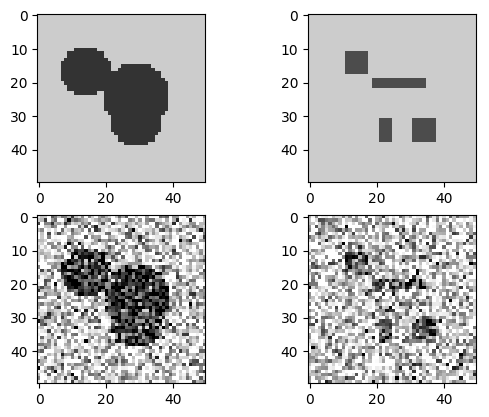

In [2]:
plt = 0
m = 50
for noise = [0, 0.3], ver = 1:2
    plt += 1
    subplot(2,2,plt)
    A = test_image(ver, m, noise)
    imshow(A[:,:,[1,1,1]])
end

Clearly, it appears much more difficult to identify the objects and the boundaries with a large amount of noise. The method we will implement here is particularly good at handling these cases.

### Level sets and contour plotting

The Chan-Vese method is based on the *levelset method*. A function $\Phi(x,y)$ is used to represent an interface as a zero contour, that is, the points $x,y$ where $\Phi(x,y)=0$. For example, a circle centered at $x_0,y_0$ with radius $r$ can be represented by the function

$$
\Phi(x,y) = \sqrt{(x-x_0)^2 + (y-y_0)^2} - r
$$

This is implemented in the function below, which creates a matrix $\Phi$ of given size `sz` and initializes it to values that represent a large circle.

In [3]:
function initial_value(sz)
    m,n = sz
    Φ = [sqrt((i - m/2)^2 + (j - n/2)^2) - 0.4n for i = 1:m, j = 1:n]
end

initial_value (generic function with 1 method)

The `contour` function can be used to plot the zero contour for this matrix $\Phi$:

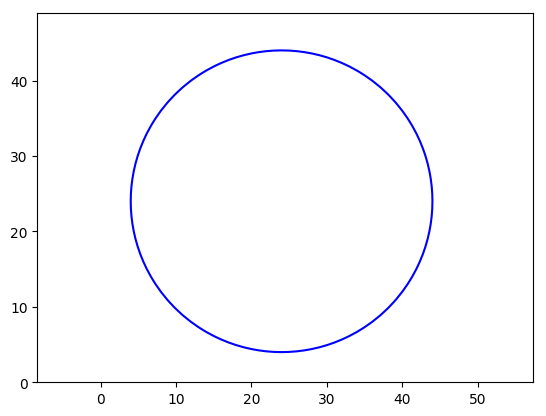

In [4]:
Φ = initial_value([50,50])
contour(Φ, [0.0], colors="b")
axis("equal");

### Algorithm

The segmentation method is based on starting from an initial matrix $\Phi$, and evolving the interface using the expressions below. With certain assumptions on the image matrix $A$, the zero contour $\Phi(x,y)=0$ will align with the boundaries of the objects in the image.

First, we define so-called smoothed Heaviside and delta functions:

$$
\begin{align*}
H(t) &= \frac12 \left(1 + \frac{2}{\pi} \arctan(t)\right) \\
\delta(t) &= \frac{d}{dt}H(t) = \frac{1}{\pi(t^2+1)}
\end{align*}
$$

For an image matrix $A$ and a levelset matrix $\Phi$, both of size $m$-by-$n$, we define the following scalars:

$$
\begin{align*}
c_1 &= \frac{\sum_{i=1}^m \sum_{j=1}^n A_{ij} H(\Phi_{ij})}
            {\sum_{i=1}^m \sum_{j=1}^n H(\Phi_{ij})} \\
c_2 &= \frac{\sum_{i=1}^m \sum_{j=1}^n A_{ij} (1 - H(\Phi_{ij}))}
            {\sum_{i=1}^m \sum_{j=1}^n (1 - H(\Phi_{ij}))}
\end{align*}
$$

Next we define an *update matrix* $\Delta \Phi$ of size $m$-by-$n$ as follows:

$$
\Delta\Phi_{ij} =
\begin{cases}
0 & \text{if }i=1\text{ or }i=m\text{ or }j=1\text{ or }j=n \\
100\delta(\Phi_{ij})\left(0.2\kappa_{ij} - (A_{ij} - c_1)^2 + (A_{ij} - c_2)^2\right) & \text{otherwise.}
\end{cases}
$$

Here, the curvature $\kappa_{ij}$ is defined by the following expressions:

$$
\begin{align*}
\Phi^{xx}_{ij} &= \Phi_{i+1,j} - 2\Phi_{ij} + \Phi_{i-1,j} \\
\Phi^{yy}_{ij} &= \Phi_{i,j+1} - 2\Phi_{ij} + \Phi_{i,j-1} \\
\Phi^{xy}_{ij} &= (\Phi_{i+1,j+1} - \Phi_{i-1,j+1} - \Phi_{i+1,j-1} + \Phi_{i-1,j-1}) / 4 \\
\Phi^{x}_{ij} &= (\Phi_{i+1,j} - \Phi_{i-1,j}) / 2 \\
\Phi^{y}_{ij} &= (\Phi_{i,j+1} - \Phi_{i,j-1}) / 2 \\
\kappa^0_{ij} &= \frac{\Phi^{xx}_{ij}(\Phi^{y}_{ij})^2 - 2\Phi^{x}_{ij}\Phi^{y}_{ij}\Phi^{xy}_{ij}
+ \Phi^{yy}_{ij}(\Phi^{x}_{ij})^2}{((\Phi^{x}_{ij})^2 + (\Phi^{y}_{ij})^2)^{3/2} + 10^{-6}} \\
\kappa_{ij} &= \max(\min(\kappa^0_{ij}, 5), -5)
\end{align*}
$$

Finally, the algorithm performs the following steps iteratively:

* Compute $c_1,c_2$
* Compute the update matrix $\Delta\Phi$
* Update $\Phi \rightarrow \Phi + \Delta\Phi$
* Repeat until $\max_{ij} |\Delta\Phi_{ij}| < 2\cdot 10^{-2}$

### Problem 1

Implement the functions `H(t)` and `δ(t)`.

In [5]:
H(t) = 1/2 + atan(t)/π;
δ(t) = 1/π/(t^2 + 1);

### Problem 2

Implement a function `coefficients(Φ, A)` which computes and returns $c_1,c_2$
for input matrices $\Phi$ and $A$.

In [6]:
function coefficients(Φ, A)
    m = size(A,1); n = size(A,2)
    c1 = sum(A[i,j]*H(Φ[i,j]) for i = 1:m, j = 1:n) / sum(H(Φ[i,j]) for i = 1:m, j = 1:n)
    c2 = sum(A[i,j]*(1 - H(Φ[i,j])) for i = 1:m, j = 1:n) / sum((1 - H(Φ[i,j])) for i = 1:m, j = 1:n)
    return c1,c2
end

coefficients (generic function with 1 method)

### Problem 3

Implement a function `update(Φ, A)` which computes and returns the update matrix $\Delta\Phi$ for
input matrices $\Phi$ and $A$.

In [7]:
function update(Φ, A) # assuming matrices are at least 3x3(otherwise ΔΦ is trivial 0 matrix)
    m = size(A,1); n = size(A,2)
    ΔΦ = zeros(m,n)
    c1,c2 = coefficients(Φ, A)
    for i = 2:m-1
        for j = 2:n-1
            Φxx = Φ[i+1,j] - 2Φ[i,j] + Φ[i-1,j] 
            Φyy = Φ[i,j+1] - 2Φ[i,j] + Φ[i,j-1] 
            Φxy = (Φ[i+1,j+1] - Φ[i-1,j+1] - Φ[i+1,j-1] + Φ[i-1,j-1]) / 4 
            Φx = (Φ[i+1,j] - Φ[i-1,j]) / 2 
            Φy = (Φ[i,j+1] - Φ[i,j-1]) / 2 
            κ0 = (Φxx*(Φy)^2 - 2Φx*Φy*Φxy + Φyy*(Φx)^2)/(((Φx)^2 + (Φy)^2)^(3/2) + 1e-6)
            κ = max(min(κ0,5.0), -5.0)
            ΔΦ[i,j] = 100*δ(Φ[i,j])*(0.2κ - (A[i,j] - c1)^2 + (A[i,j] - c2)^2)
        end
    end
    return  ΔΦ
end

update (generic function with 1 method)

### Problem 4

Implement a function `image_segment(A; maxiter=100000)` which implements the algorithm as described above, that is:

* Start by initializing $\Phi$ using the `initial_value` function
* Iterate at most `maxiter` times
* Compute updates $\Delta\Phi$ and add to $\Phi$
* Terminate if $\max_{ij} |\Delta\Phi_{ij}| < 2\cdot 10^{-2}$

The function finally returns $\Phi$ (whether it terminated early or not).

In [8]:
function image_segment(A; maxiter=100000)
    Φ = initial_value([50,50])
    iter = 0
    ΔΦ = ones(size(Φ,1),size(Φ,2))
    while maximum(abs.(ΔΦ)) >= 2*1e-2 && iter <= maxiter
        ΔΦ = update(Φ, A)
        Φ = Φ .+ ΔΦ
        iter +=1
    end
    return Φ
end

image_segment (generic function with 1 method)

### Problem 5

When you are convinced that your functions work as expected, demonstrate image segmentation for the
four test images above by running the code below.

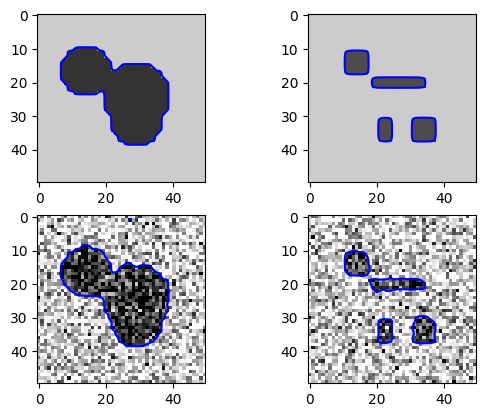

In [9]:
plt = 0
m = 50
for noise = [0, 0.3], ver = 1:2
    plt += 1
    subplot(2,2,plt)
    A = test_image(ver, m, noise)
    Φ = image_segment(A)
    imshow(A[:,:,[1,1,1]])
    contour(Φ, [0.0], colors="b")
end